In [3]:
import os
import sys
import datetime
import scanorama
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sps
import matplotlib.pyplot as plt

from pathlib import Path
from os.path import join
from functools import reduce
from sklearn.metrics import pairwise_distances

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
# %matplotlib inline

dno = 'imm_human'
data_dir = join('/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Data', dno)
out_dir  = join('/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Output', dno)

sc.settings.set_figure_params(dpi=80)
sc.settings.figdir = Path(f'/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Output/{dno}/scanorama')
sc.settings.figdir.mkdir(parents=True, exist_ok=True)

min_cells = 3
npcs = 50
sf = 1e4
n_hvgs = 2000
n_neighs = 10

batch_key = 'batch'
label_key = 'final_annotation'

adata = sc.read_h5ad(join(data_dir, 'Immune_ALL_human.h5ad'))  # normazlized data

sc.pp.highly_variable_genes(adata, n_top_genes= n_hvgs, 
#                             min_mean=0.0125, max_mean=3, min_disp=0.5,
                            batch_key=batch_key)

adata = adata[:, adata.var.highly_variable].copy()
# sc.pp.scale(adata, max_value=None)

# split by batch
Xs = []
for bi in adata.obs.batch.unique():
    cell_bi = adata.obs.batch == bi
    adata_batch = adata[cell_bi].copy()
    sc.pp.scale(adata_batch)
    Xs.append(adata_batch)
    print(f'n of {bi} = {cell_bi.sum()}, {len(Xs[-1])}')

corrected = scanorama.correct_scanpy(Xs, return_dimred=True, dimred=npcs)

ada_sca = sc.concat(corrected)
ada_sca.obsm["X_emb"] = ada_sca.obsm['X_scanorama']

from evaluation import scib_process
ada_sca.obs[[batch_key, label_key]] = ada_sca.obs[[batch_key, label_key]].astype('category')

tmp_res = scib_process(ada_sca,
                        batch_key=batch_key,
                        label_key=label_key,
                        nmi_=True, nmi_method='arithmetic', save_nmi=None,
                        ari_=True,
                        silhouette_=True, si_metric='euclidean',
                        # pcr_=pcr_,
                        # cell_cycle_=cell_cycle_, organism=organism,
                        isolated_labels_=False, n_isolated=None,
                        graph_conn_=False,
                        type_='emb',
                        subsample=0.5,  # for kBET
                        kBET_ = False,   
                        clisi_= False,
                        ilisi_= False)

tmp_res.to_csv(join(out_dir,  f'scanorama/{dno}_emb_eval.csv'), index=True, sep=',')


/home/yxh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


n of Oetjen_A = 2586, 2586
n of Oetjen_P = 3265, 3265
n of Oetjen_U = 3730, 3730
n of Freytag = 3347, 3347
n of 10X = 10727, 10727
n of Sun_sample1_CS = 1725, 1725
n of Sun_sample2_KC = 2281, 2281
n of Sun_sample3_TB = 2403, 2403
n of Sun_sample4_TC = 2420, 2420
n of Villani = 1022, 1022
Found 2000 genes among all datasets
[[0.         0.66821346 0.85692189 0.10170147 0.20146945 0.06144928
  0.02937308 0.08198086 0.05916473 0.01272016]
 [0.         0.         0.4463807  0.04242605 0.03062787 0.01971014
  0.00876808 0.01831045 0.00991736 0.02152642]
 [0.         0.         0.         0.47077748 0.47292225 0.25797101
  0.18412977 0.28547649 0.20826446 0.00782779]
 [0.         0.         0.         0.         0.55183747 0.55188406
  0.28452433 0.45776113 0.50371901 0.03620352]
 [0.         0.         0.         0.         0.         0.49449275
  0.76764577 0.45484811 0.37438017 0.2074364 ]
 [0.         0.         0.         0.         0.         0.
  0.50782609 0.62898551 0.57449275 0.002

... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'sample_ID' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical


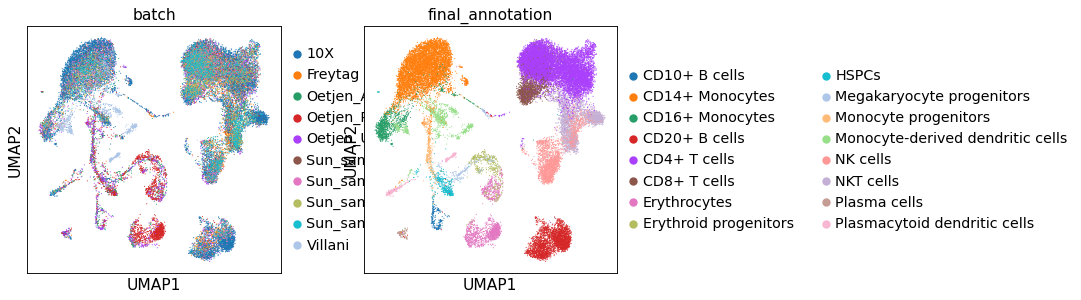

In [4]:
sc.pp.neighbors(ada_sca, n_neighbors=n_neighs, use_rep='X_scanorama') # use raw.X    
sc.tl.umap(ada_sca)
sc.pl.umap(ada_sca, color=[batch_key, label_key])

os.makedirs(join(out_dir, 'scanorama/h5ad'), exist_ok=True)
ada_sca.write(join(out_dir, f'scanorama/h5ad/{dno}_emb.h5ad'))